In [1]:
%load_ext autoreload
%autoreload 2

# Dependencies

In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys, os
import json
import numpy as np
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import os
import json
import tensorflow as tf
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

root = os.path.abspath(os.path.join(os.getcwd(), "..",))
sys.path.append(root)


from src.model import FixCapsNet
from src.utils import ImageShow, draw_size_acc, one_hot, confusion_matrix, metrics_scores, pff

# Settings

In [3]:
# Settings.
if torch.cuda.is_available():
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    print("CUDA Available: ", False)
    print("Using CPU instead")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# Reduce VRAM usage by reducing fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

CUDA Device Count:  1
CUDA Device Name:  Quadro T2000


In [4]:
img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

# Visualization

In [5]:
data_folder = os.path.join(root, "data")
train_dataset = os.path.join(data_folder, "train")
val_dataset = os.path.join(data_folder, "val")
test_dataset = os.path.join(data_folder, "test")
print(train_dataset)
print(val_dataset)
print(test_dataset)

d:\Code\NCKH2025\CNN\data\train
d:\Code\NCKH2025\CNN\data\val
d:\Code\NCKH2025\CNN\data\test


In [6]:
def count_files_in_subfolders(data_folder):
    counts = {}
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(data_folder, subset)
        file_count = 0
        if os.path.exists(subset_path):
            # Count files in the directory and its subdirectories
            for dirpath, dirnames, filenames in os.walk(subset_path):
                file_count += len(filenames)
            counts[subset] = file_count
    return counts

file_counts = count_files_in_subfolders(data_folder)

# Print the results
for subset, count in file_counts.items():
    print(f"{subset.capitalize()}: {count} files.")


Train: 8010 files.
Val: 2005 files.
Test: 1511 files.


In [7]:
def count_files_in_folder(data_folder, folder_name):
    train_path = os.path.join(data_folder, folder_name)
    file_counts = {}
    
    if os.path.exists(train_path):
        for dirpath, dirnames, filenames in os.walk(train_path):
            for dirname in dirnames:
                subfolder_path = os.path.join(dirpath, dirname)
                # Count only files in the subfolder
                file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
                file_counts[dirname] = file_count
                
    return file_counts

def plot_distribution(data_folder, folder_names):
    # Prepare data for the bar chart
    distributions = {folder: count_files_in_folder(data_folder, folder) for folder in folder_names}
    labels = list(distributions[folder_names[0]].keys())  # Assumes all folders have the same classes

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Set the width of each bar
    bar_width = 0.25
    bar_positions = [i for i in range(len(labels))]

    # Plot data for each folder
    for idx, folder_name in enumerate(folder_names):
        values = [distributions[folder_name].get(label, 0) for label in labels]
        bar_pos_offset = [pos + (idx * bar_width) for pos in bar_positions]
        plt.bar(bar_pos_offset, values, width=bar_width, label=f'{folder_name} distribution')

    # Add data labels on top of the bars
    for idx, folder_name in enumerate(folder_names):
        values = [distributions[folder_name].get(label, 0) for label in labels]
        bar_pos_offset = [pos + (idx * bar_width) for pos in bar_positions]
        for pos, yval in zip(bar_pos_offset, values):
            plt.text(pos, yval, int(yval), ha='center', va='bottom', fontsize=10)

    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Set labels and title
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Datas', fontsize=12)
    plt.title("Train, Validation, and Test Data Distribution", fontsize=14)
    plt.xticks([pos + bar_width for pos in bar_positions], labels, rotation=45, fontsize=10)
    plt.legend()

    # Make layout adjustments
    plt.tight_layout()

    # Show the plot
    plt.show()


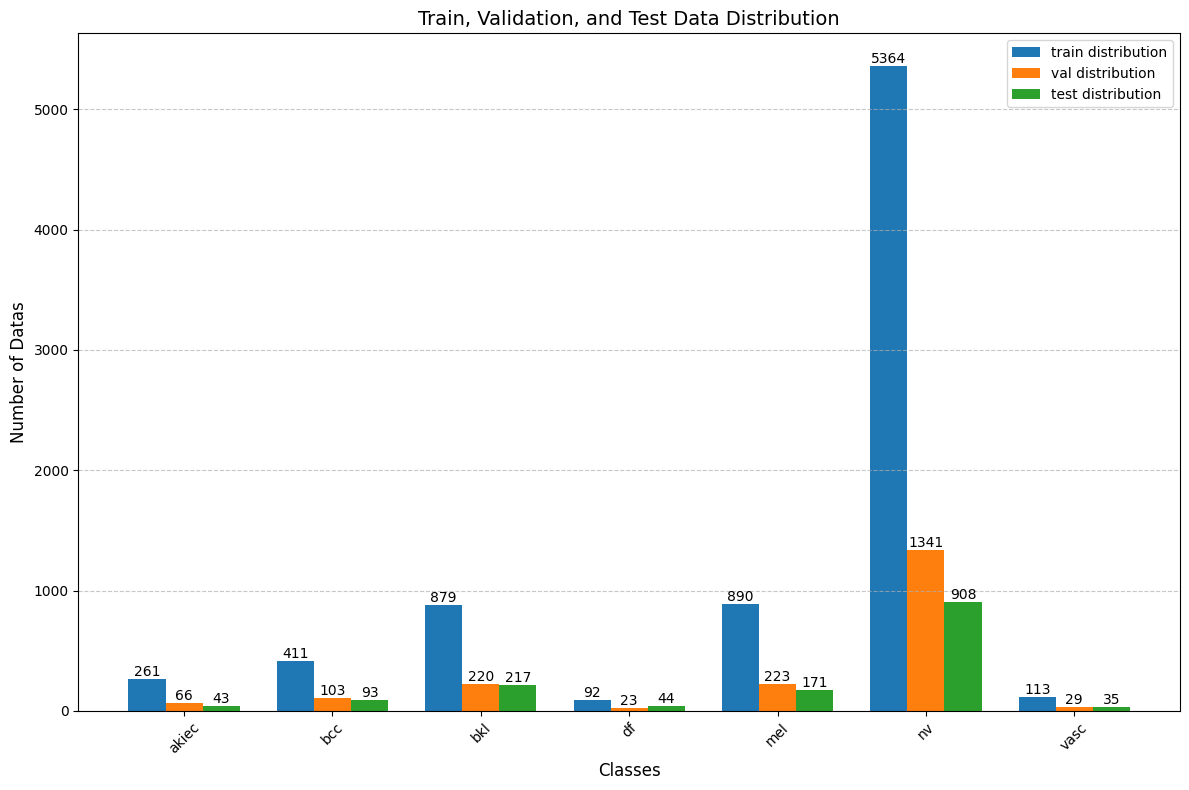

In [8]:
plot_distribution(data_folder, ['train', 'val', 'test'])

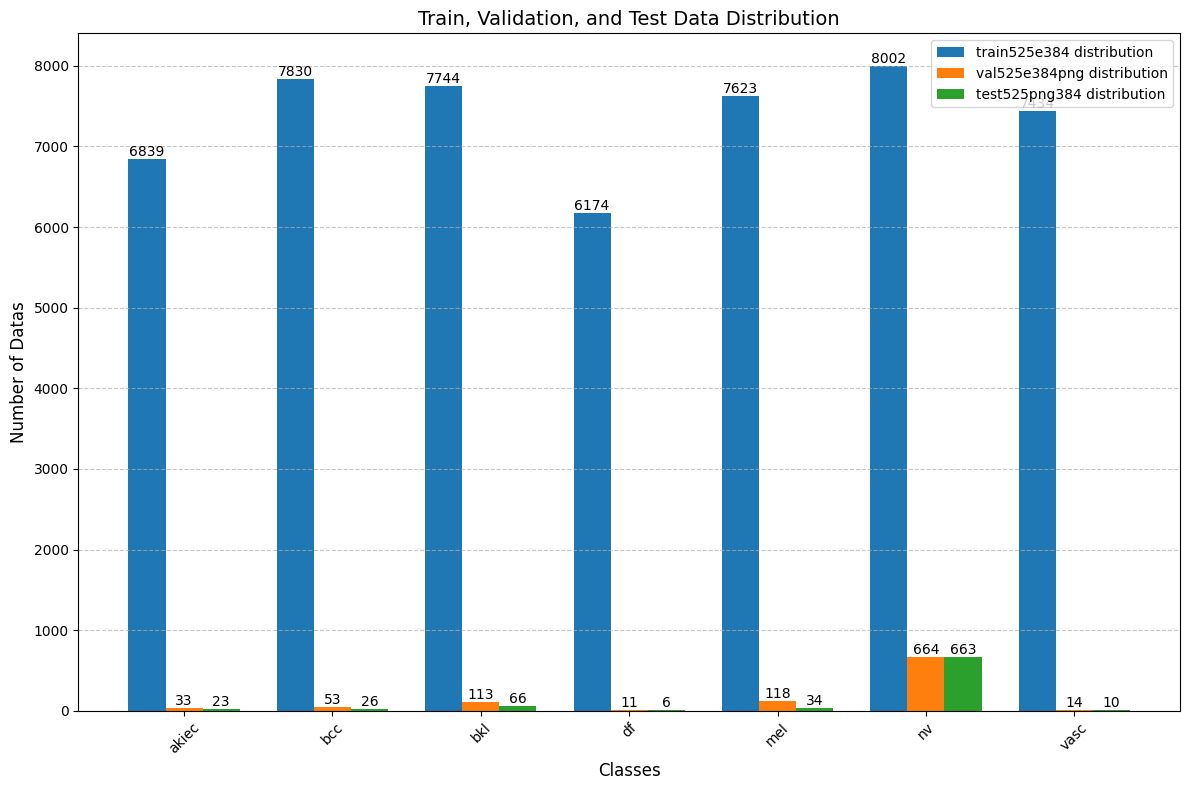

In [9]:
plot_distribution(data_folder, ['train525e384', 'val525e384png', 'test525png384'])

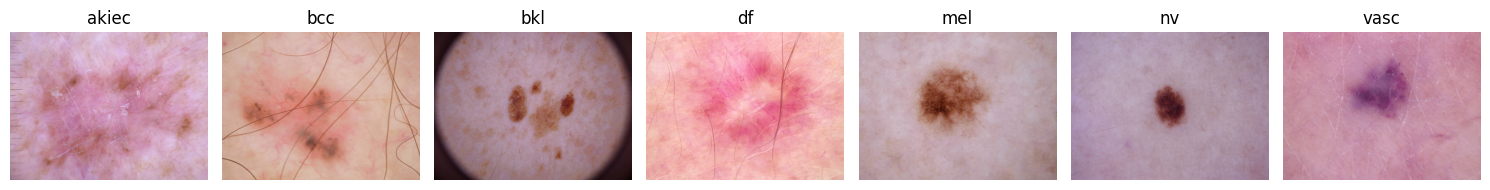

In [10]:
def load_one_image_per_class(data_folder):
    train_path = os.path.join(data_folder, 'train')
    images_per_class = {}
    
    if os.path.exists(train_path):
        for dirpath, dirnames, filenames in os.walk(train_path):
            for dirname in dirnames:
                subfolder_path = os.path.join(dirpath, dirname)
                # Get all image files in the subfolder
                image_files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
                if image_files:
                    # Randomly select one image
                    selected_image = random.choice(image_files)
                    images_per_class[dirname] = os.path.join(subfolder_path, selected_image)
                    
    return images_per_class

images_per_class = load_one_image_per_class(data_folder)

# Display the images in one line
plt.figure(figsize=(15, 5))  # Set the figure size
for i, (label, image_path) in enumerate(images_per_class.items()):
    img = mpimg.imread(image_path)  # Load the image
    plt.subplot(1, len(images_per_class), i + 1)  # Create a subplot for each image in one row
    plt.imshow(img)  # Display the image
    plt.title(label)  # Set the title as the class label
    plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [11]:
class_names = [d for d in os.listdir(train_dataset) if os.path.isdir(os.path.join(train_dataset, d))]
n_classes = len(class_names)
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Loading

In [12]:
def get_data(trans_test='312'):
    global train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    image_path = os.path.join(root, data_folder)#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

# Define Model

In [13]:
BatchSize = 32
V_size = 40 
T_size = 32 
train_doc = "train525e384"
val_doc = "val525e384png"
test_doc = "test525png384"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.


In [14]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 141, 141]         124,544
              ReLU-2        [-1, 128, 141, 141]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [15]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [16]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

+-------------+-----------+----------+-------+
|    Model    | Params(M) | FLOPs(G) |  FPS  |
+-------------+-----------+----------+-------+
| FixCaps-128 |    0.26   |   2.48   | 52.63 |
+-------------+-----------+----------+-------+


# Define train - test function

In [17]:
def train(epoch):
    network.train()
    global best_train, train_evl_result
    running_loss, r_pre = 0., 0.
    print_step = len(train_loader) // 2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes, n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        # Forward pass
        output = network(data)
        loss = network.loss(output, target, size_average=True)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update running loss
        running_loss += loss.item()
        
        # Prediction
        v_mag = torch.sqrt(torch.sum(output ** 2, dim=2, keepdim=True))
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre / (batch_idx * BatchSize)
        
        # Print intermediate results
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss:{:.5f}, ACC:{:.5f}".format(batch_idx, len(train_loader), loss, tmp_pre))
        
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] += 1

        # Save the model if the training accuracy improves
        if best_train < tmp_pre and tmp_pre >= 80:
            torch.save(network.state_dict(), iter_path)
        
    # Calculate epoch loss and accuracy
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    scheduler.step(epoch_loss)  # Step the scheduler based on epoch loss

    # Save the model if the best training accuracy improves
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f}, Acc:{:.5f}, Best_train:{:.5f}".format(epoch, epoch_loss, epoch_acc, best_train))

    return epoch_loss  # Return epoch loss for early stopping


In [18]:
def test(split="test"):
    network.eval()
    global test_acc, eval_acc, best_acc, net_parameters
    global test_evl_result, val_evl_result  # , evl_tmp_result
    cor_loss, correct, Auc, Acc = 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes, n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num

    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')

    running_loss = 0.0  # To accumulate total loss
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx += 1
            target_indices = target  # torch.Size([batch, 7])
            target_one_hot = one_hot(target, length=n_classes)
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            # Forward pass
            output = network(data)  # torch.Size([batch_size, 7, 16, 1])
            loss = network.loss(output, target, size_average=True)  # Calculate the loss
            running_loss += loss.item() * data.size(0)  # Accumulate the loss

            # Prediction and evaluation metrics
            v_mag = torch.sqrt(torch.sum(output ** 2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()  # [9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]

            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size

            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] += 1

        # Calculate accuracy
        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result)
        test_acc = 100. * float(torch.div(diag_sum, all_sum))
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc), 3)}%\033[0m")

        # Calculate average validation loss
        avg_val_loss = running_loss / data_num
        print(f"{split}_Loss: {avg_val_loss:.5f}")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()  # copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc), 3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()  # copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc), 3)}%]\033[0m")

    return avg_val_loss  # Return the average validation loss for early stopping


In [19]:
# Create store
try:
    print(f"suf: {suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf: {suf}")   

# Define the directory path
directory_path = f'./tmp/{img_title}/{suf}'

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f'Directory created: "{directory_path}"')
else:
    print(f'Store: "{directory_path}"')

# Define file paths
iter_path = f'{directory_path}/train_{img_title}_{suf}.pth'
save_PATH = f'{directory_path}/best_{img_title}_{suf}.pth'
last_path = f'{directory_path}/last_{img_title}_{suf}.pth'

print(save_PATH)


suf: 1021_015059
Directory created: "./tmp/HAM10000/1021_015059"
./tmp/HAM10000/1021_015059/best_HAM10000_1021_015059.pth


In [20]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


# Train model

In [21]:
learning_rate = 0.1
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)
early_stopping = EarlyStopping(patience=40, verbose=True)

In [22]:
num_epochs = 1000
torch.cuda.empty_cache()

for epoch in range(1, num_epochs + 1):
    train(epoch)  # Train the model

    # Validation step (assuming you have a test function that returns validation loss)
    val_loss = test('val')  # Make sure this function returns the validation loss

    # Step the scheduler based on the validation loss
    scheduler.step(val_loss)

    # Call early stopping
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    torch.cuda.empty_cache()  # Clear unused memory


[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.38298, ACC:0.37229
Train Epoch:[1] Loss:0.37702, Acc:0.41535, Best_train:0.41535
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:57.853%
val_Loss: 0.37655
Best_val:[57.853%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.36205, ACC:0.49849
Train Epoch:[2] Loss:0.32331, Acc:0.51024, Best_train:0.51024
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:65.408%
val_Loss: 0.50334
Best_val:[65.408%]
EarlyStopping counter: 1 out of 20
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.19069, ACC:0.53508
Train Epoch:[3] Loss:0.30584, Acc:0.54134, Best_train:0.54134
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:70.775%
val_Loss: 0.31994
Best_val:[70.775%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.28975, ACC:0.56215
Train Epoch:[4] Loss:0.29284, Acc:0.56490, Best_train:0.56490
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.131%
val_Loss: 0.25927
Best_val:[78.131%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.29990, ACC:0.57884
Train Epoch:[5] Loss:0.28312, Acc:0.58349, Best_train:0.58349
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.131%
val_Loss: 0.28659
Best_val:[78.131%]
EarlyStopping counter: 1 out of 20
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.27037, ACC:0.59390
Train Epoch:[6] Loss:0.27530, Acc:0.59474, Best_train:0.59474
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.026%
val_Loss: 0.23790
Best_val:[79.026%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.25815, ACC:0.60289
Train Epoch:[7] Loss:0.26884, Acc:0.60704, Best_train:0.60704
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.044%
val_Loss: 0.37955
Best_val:[79.026%]
EarlyStopping counter: 1 out of 20
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.32592, ACC:0.61784
Train Epoch:[8] Loss:0.26353, Acc:0.61838, Best_train:0.61838
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.821%
val_Loss: 0.31866
Best_val:[79.821%]
EarlyStopping counter: 2 out of 20
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.26636, ACC:0.62229
Train Epoch:[9] Loss:0.25959, Acc:0.62359, Best_train:0.62359
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.231%
val_Loss: 0.29946
Best_val:[79.821%]
EarlyStopping counter: 3 out of 20
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.19549, ACC:0.62558
Train Epoch:[10] Loss:0.25717, Acc:0.62834, Best_train:0.62834
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
val_Loss: 0.20058
Best_val:[82.803%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.29904, ACC:0.63402
Train Epoch:[11] Loss:0.25309, Acc:0.63440, Best_train:0.63440
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.915%
val_Loss: 0.25656
Best_val:[82.803%]
EarlyStopping counter: 1 out of 20
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.26274, ACC:0.64088
Train Epoch:[12] Loss:0.24970, Acc:0.64119, Best_train:0.64119
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.722%
val_Loss: 0.30370
Best_val:[82.803%]
EarlyStopping counter: 2 out of 20
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.26728, ACC:0.64947
Train Epoch:[13] Loss:0.24698, Acc:0.64679, Best_train:0.64679
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.318%
val_Loss: 0.26903
Best_val:[82.803%]
EarlyStopping counter: 3 out of 20
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.21056, ACC:0.65555
Train Epoch:[14] Loss:0.24358, Acc:0.65223, Best_train:0.65223
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.026%
val_Loss: 0.26291
Best_val:[82.803%]
EarlyStopping counter: 4 out of 20
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.17353, ACC:0.65044
Train Epoch:[15] Loss:0.24158, Acc:0.65349, Best_train:0.65349
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.201%
val_Loss: 0.24218
Best_val:[83.201%]
EarlyStopping counter: 5 out of 20
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.19686, ACC:0.65497
Train Epoch:[16] Loss:0.24001, Acc:0.65920, Best_train:0.65920
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.354%
val_Loss: 0.40664
Best_val:[83.201%]
EarlyStopping counter: 6 out of 20
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.22734, ACC:0.67677
Train Epoch:[17] Loss:0.22790, Acc:0.67827, Best_train:0.67827
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.107%
val_Loss: 0.25901
Best_val:[83.201%]
EarlyStopping counter: 7 out of 20
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.18476, ACC:0.68146
Train Epoch:[18] Loss:0.22458, Acc:0.68360, Best_train:0.68360
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.101%
val_Loss: 0.25543
Best_val:[83.201%]
EarlyStopping counter: 8 out of 20
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.16843, ACC:0.68525
Train Epoch:[19] Loss:0.22406, Acc:0.68441, Best_train:0.68441
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.417%
val_Loss: 0.25810
Best_val:[83.201%]
EarlyStopping counter: 9 out of 20
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.20210, ACC:0.68401
Train Epoch:[20] Loss:0.22286, Acc:0.68778, Best_train:0.68778
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.101%
val_Loss: 0.24279
Best_val:[83.201%]
EarlyStopping counter: 10 out of 20
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.21140, ACC:0.69180
Train Epoch:[21] Loss:0.22123, Acc:0.69093, Best_train:0.69093
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.4%
val_Loss: 0.23814
Best_val:[83.4%]
EarlyStopping counter: 11 out of 20
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.21981, ACC:0.69424
Train Epoch:[22] Loss:0.21943, Acc:0.69293, Best_train:0.69293
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.201%
val_Loss: 0.24704
Best_val:[83.4%]
EarlyStopping counter: 12 out of 20
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.27929, ACC:0.69099
Train Epoch:[23] Loss:0.21942, Acc:0.69425, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.996%
val_Loss: 0.23141
Best_val:[83.996%]
EarlyStopping counter: 13 out of 20
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.23990, ACC:0.68982
Train Epoch:[24] Loss:0.22030, Acc:0.69109, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.499%
val_Loss: 0.24934
Best_val:[83.996%]
EarlyStopping counter: 14 out of 20
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.21891, ACC:0.69126
Train Epoch:[25] Loss:0.22077, Acc:0.68919, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.698%
val_Loss: 0.23813
Best_val:[83.996%]
EarlyStopping counter: 15 out of 20
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.18491, ACC:0.69362
Train Epoch:[26] Loss:0.21968, Acc:0.69304, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
val_Loss: 0.24252
Best_val:[83.996%]
EarlyStopping counter: 16 out of 20
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.19481, ACC:0.68986
Train Epoch:[27] Loss:0.21956, Acc:0.69200, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.195%
val_Loss: 0.24531
Best_val:[84.195%]
EarlyStopping counter: 17 out of 20
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.24289, ACC:0.69776
Train Epoch:[28] Loss:0.22009, Acc:0.69339, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
val_Loss: 0.24265
Best_val:[84.195%]
EarlyStopping counter: 18 out of 20
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.33633, ACC:0.69250
Train Epoch:[29] Loss:0.21924, Acc:0.69272, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.294%
val_Loss: 0.23938
Best_val:[84.294%]
EarlyStopping counter: 19 out of 20
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/1614 [00:00<?, ?it/s]

[807/1614] Loss:0.19482, ACC:0.69610
Train Epoch:[30] Loss:0.21941, Acc:0.69341, Best_train:0.69425
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
val_Loss: 0.23339
Best_val:[84.294%]
EarlyStopping counter: 20 out of 20
Early stopping triggered


# Train Result

In [23]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [29]
[Val] ACC:84.29%.


In [24]:
network.load_state_dict(torch.load(save_PATH))

for k in range(22,33):
    T_size = k
    print(f"T_size:{k}")
    for i in range(300,325):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc                 

C:\Users\ToanGTV\AppData\Local\Temp\ipykernel_7416\2496153802.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(save_PATH))


T_size:22
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20577
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20768
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.20707
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20705
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20708
Best_eval:[88.889%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20529
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20647
Best_eval:[88.889%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20520
Best_eval:[89.01%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.20823
Best_eval:[89.01%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.20212
Best_eval:[89.493%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20579
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20375
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20224
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.20363
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20360
Best_eval:[89.493%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20332
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20297
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20354
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20211
Best_eval:[89.493%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19960
Best_eval:[89.734%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19755
Best_eval:[89.734%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20557
Best_eval:[89.734%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20376
Best_eval:[89.734%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20334
Best_eval:[89.734%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.20046
Best_eval:[89.734%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20371
Best_eval:[89.734%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.20197
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19576
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.20196
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19919
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20077
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.20357
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20181
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20326
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.20088
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19928
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.20104
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19447
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19832
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.20036
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19764
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20094
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20116
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19808
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20078
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19692
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.20030
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19905
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19576
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19623
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19856
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19617
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19771
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20055
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19824
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19782
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19476
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19756
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19801
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19829
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19393
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20000
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19570
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19754
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19464
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19274
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19668
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.20025
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19316
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19086
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19567
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19915
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19736
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19285
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19695
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19444
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19362
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19360
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19746
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19695
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19145
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19587
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19333
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19569
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19351
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19165
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19151
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19232
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19620
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19192
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19067
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19209
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19401
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19268
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18787
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18844
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18929
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19070
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19131
Best_eval:[89.855%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18972
Best_eval:[89.855%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18641
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18668
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19069
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18728
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19058
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18637
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19073
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18993
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18716
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18686
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18707
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18742
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18885
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18833
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18895
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18424
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18774
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18696
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18367
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18710
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18223
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18662
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18378
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18272
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.18402
Best_eval:[89.976%]
T_size:23
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20417
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20428
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20554
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20319
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.20290
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19733
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20167
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19943
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20103
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:87.923%
test_Loss: 0.20653
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20091
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20013
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20281
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20277
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.20124
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20029
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20390
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20063
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20216
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19949
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20438
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19873
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20139
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19878
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19817
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19670
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19862
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19856
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19865
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19648
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19845
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19830
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.19845
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19818
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19970
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19732
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19560
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19674
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19499
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19724
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19686
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.20209
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19741
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19359
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19652
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19547
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19545
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19564
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19677
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19617
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19856
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19490
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19330
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.19754
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19372
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19452
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19453
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19507
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19288
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19394
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19084
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18748
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19108
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19363
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19280
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19677
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19308
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19425
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19101
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18949
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18953
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19278
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19059
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18922
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19344
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19108
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19123
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19099
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19068
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18896
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18895
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18936
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19009
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18927
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18945
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19071
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19052
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18996
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19103
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18715
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19006
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18969
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18928
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18946
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19039
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18915
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18841
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18848
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.18921
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18896
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18387
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18681
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18833
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18600
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18609
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18627
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18579
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18880
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18705
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18365
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18755
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18316
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18355
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18423
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18616
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.17983
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18498
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18344
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18435
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18186
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.17936
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18197
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18082
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18082
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18131
Best_eval:[89.976%]
T_size:24
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.19223
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18955
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18920
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19115
Best_eval:[89.976%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.19009
Best_eval:[89.976%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18623
Best_eval:[90.217%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18585
Best_eval:[90.217%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.18641
Best_eval:[90.338%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18656
Best_eval:[90.338%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.18961
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18853
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18789
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18422
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.18717
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18750
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18613
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.18311
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18478
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.18479
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18567
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18652
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.18231
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18719
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18428
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18251
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18313
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18737
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.18188
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18383
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18391
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18412
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.18321
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18442
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18301
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.18097
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.18302
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18340
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18241
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.18020
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18060
Best_eval:[90.821%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18026
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18074
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18037
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18131
Best_eval:[90.821%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17538
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17806
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17798
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.18077
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.18162
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17934
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17901
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17643
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.18015
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17764
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.18032
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17602
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17891
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.17679
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17801
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17674
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.17456
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.17345
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17853
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17579
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17871
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17640
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17682
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17504
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17478
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.17587
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17755
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17727
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17647
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17794
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17326
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17261
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17548
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17412
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17368
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17330
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17426
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16987
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17420
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.17334
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17476
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17256
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.17182
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.17084
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17407
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.17106
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.17213
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17358
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.17213
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17450
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17276
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.17155
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16943
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16871
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17037
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17177
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16939
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.17022
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16932
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16785
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16754
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.17050
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.17198
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16686
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16699
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16937
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16946
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16897
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16933
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16779
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16892
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16702
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16776
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16572
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16769
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16827
Best_eval:[91.184%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16505
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16766
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16775
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16647
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16500
Best_eval:[91.184%]
T_size:25
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17760
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17728
Best_eval:[91.184%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.17612
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.17736
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.18046
Best_eval:[91.667%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17799
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.18032
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17384
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17666
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17709
Best_eval:[91.667%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.17400
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17386
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.17633
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17384
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.17693
Best_eval:[91.667%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
test_Loss: 0.17300
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17811
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.17531
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
test_Loss: 0.17319
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17148
Best_eval:[91.787%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17224
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.17376
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.17157
Best_eval:[91.787%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
test_Loss: 0.17101
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.17479
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17192
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.17159
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.17315
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.17149
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17336
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17116
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17126
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17485
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.17168
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.17266
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17034
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.17190
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.17040
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17146
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16961
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
test_Loss: 0.16821
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16866
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.17035
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16855
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16993
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16994
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16935
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16848
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.17207
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.17113
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.16893
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16966
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16681
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
test_Loss: 0.16670
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16757
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16618
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16673
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16658
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.16721
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16388
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16709
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16440
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16650
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
test_Loss: 0.16520
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16616
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16677
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16596
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16397
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16659
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16547
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.16333
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16374
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16236
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16511
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.16335
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16455
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16314
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16393
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.16376
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16631
Best_eval:[92.029%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16378
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16240
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16323
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
test_Loss: 0.16184
Best_eval:[92.029%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
test_Loss: 0.16324
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.15%
test_Loss: 0.16313
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16472
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16317
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16374
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16165
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16199
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.16162
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16193
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16233
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16253
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16272
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.16133
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16192
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16276
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.16132
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15881
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.15856
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
test_Loss: 0.15864
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15928
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15967
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15827
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.16133
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16201
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15891
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15925
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15905
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15704
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15891
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
test_Loss: 0.15665
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15789
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15689
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15785
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15748
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15855
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15690
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15582
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15492
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15605
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15753
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15679
Best_eval:[92.271%]
T_size:26
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17429
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17196
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17423
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.17111
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.17340
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17232
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16929
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17327
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.17171
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.17427
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16783
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16993
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.17031
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.17098
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16995
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16882
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.17363
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16860
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.17028
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16860
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16667
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16697
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16763
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16673
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16738
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16890
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16767
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16779
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16715
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16684
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16604
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16631
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16865
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16696
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16636
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16511
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16532
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16442
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16546
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16586
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.16485
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16331
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16288
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16326
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16406
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16331
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16352
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16419
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.16385
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16236
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15966
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16110
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16294
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.16021
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16199
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16163
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16122
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.16067
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15860
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.16088
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16045
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16004
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15902
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15843
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15905
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15988
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15819
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15780
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15953
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15845
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15758
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15880
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15694
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15702
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15741
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15572
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15969
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15897
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15742
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15633
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15657
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15715
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15742
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15835
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15531
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15678
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15816
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15687
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15689
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15547
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15447
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15464
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15638
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15617
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15566
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15482
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15491
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15396
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15413
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15214
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15463
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15349
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15231
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15429
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15298
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15304
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15180
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15279
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15328
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15210
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15264
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15039
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15175
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15380
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15319
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15146
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15087
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15103
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15100
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15163
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14982
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15082
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15128
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15151
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15121
Best_eval:[92.271%]
T_size:27
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.16641
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16776
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16668
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16857
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16976
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16490
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.16705
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16458
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16683
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16573
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16572
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16362
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16578
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16491
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16439
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16339
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16366
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.16498
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16429
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.16630
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16242
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16327
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16088
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.16248
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.16476
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16186
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16084
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.16093
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16137
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16214
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16108
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16057
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16074
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16130
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16008
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15974
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15873
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15985
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16021
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15873
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15859
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15762
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15843
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16027
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15936
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15760
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15934
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15827
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15784
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15787
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15706
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15604
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15644
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15653
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15570
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15695
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15488
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15561
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.15684
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15578
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15668
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15627
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15751
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15590
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15648
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15446
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.15444
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15351
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15460
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15541
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15216
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15331
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15382
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15253
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15333
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15206
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.15246
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15540
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15239
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15259
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15219
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15260
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15187
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15193
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15149
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.15248
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15130
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15096
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15169
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15273
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15072
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15081
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15125
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15101
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15082
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15053
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15051
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15044
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15084
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15045
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15045
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.14861
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.14998
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15056
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.14976
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.14882
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.14876
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.14832
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.14846
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.14917
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.14898
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.14871
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.14713
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.14610
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.14947
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.14772
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.14716
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.14769
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.14796
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.14733
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.14710
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.14689
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.14678
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.14739
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.14651
Best_eval:[92.271%]
T_size:28
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16742
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16848
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16858
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16643
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16733
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16542
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16445
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16508
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16668
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16684
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16441
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16690
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16641
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16545
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16403
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16600
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16433
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16411
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16398
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16500
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16298
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16437
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16558
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16427
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16350
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16383
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16134
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16232
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16406
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16283
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16358
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16210
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16202
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16122
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16271
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16179
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16170
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16163
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16141
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16167
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16105
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16213
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16194
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16218
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16179
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16036
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16123
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16071
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15986
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16213
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15951
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15950
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15975
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15810
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16041
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15864
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15797
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15874
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15922
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15947
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15921
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15809
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15850
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15839
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15947
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15716
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15886
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15734
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15749
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15672
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15805
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15798
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15863
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15938
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15782
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15661
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15695
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15675
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15744
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15548
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.15818
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15677
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15690
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15523
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15661
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15615
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15547
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15607
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15656
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15523
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.15434
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15437
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15519
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15505
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15605
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15366
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15517
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15512
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15521
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15488
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15357
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15262
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15414
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15159
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15473
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15270
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15355
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15262
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15351
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15339
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15335
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15299
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15303
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15265
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15288
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15265
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15183
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15128
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15078
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15182
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14999
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15050
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15072
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15058
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15011
Best_eval:[92.271%]
T_size:29
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.17254
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.17107
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16989
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.17211
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.17291
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.17131
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16971
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16990
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.17144
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.17195
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16890
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16891
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16990
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.17125
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16932
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16938
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16955
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16865
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16995
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16847
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16968
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16888
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16781
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16908
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16972
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16542
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16748
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16642
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16624
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.16669
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16608
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16450
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16617
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16612
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16536
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16559
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16432
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16605
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16756
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16547
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16434
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.16478
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.16543
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16363
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16568
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16389
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16268
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.16411
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16385
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.16388
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16068
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16351
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16300
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16367
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16150
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16085
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16200
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.16149
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16118
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16182
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.16047
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16156
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15924
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16072
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16121
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16135
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15961
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16013
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15988
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15950
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16015
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15997
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16126
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16138
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15924
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15862
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15898
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15932
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15949
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16023
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15815
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15846
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15681
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15780
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15866
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15794
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15815
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15878
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15787
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15658
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15736
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15657
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15667
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15731
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15666
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15611
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15654
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15705
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15668
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15753
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15586
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15559
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15674
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15700
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15509
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15694
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15543
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15701
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15639
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15475
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15616
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15510
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15487
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15537
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15485
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15374
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15475
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15385
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15337
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15527
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15290
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15318
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15446
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15291
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15356
Best_eval:[92.271%]
T_size:30
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16157
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.16177
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16262
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.16086
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.16204
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15974
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.16046
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.16015
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15868
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.16066
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.16057
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15978
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15899
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15822
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15771
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15845
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.15984
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15788
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15794
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15829
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15814
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15797
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15775
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15873
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15770
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15507
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15637
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15656
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15771
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15652
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15539
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15639
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15564
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15512
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15674
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15593
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15350
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15389
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15494
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15444
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15538
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15407
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15500
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15491
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15562
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15439
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15410
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15345
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15334
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15253
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15325
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15326
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15339
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15355
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15227
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15316
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15289
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15171
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15238
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.15292
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15129
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15195
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15278
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15249
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15205
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15171
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.15173
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15014
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15085
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15139
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15114
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15072
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.15084
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15077
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15064
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14986
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14911
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15012
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15100
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15134
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14980
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14977
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14919
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15014
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.15024
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14822
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14884
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14771
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15000
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14799
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14805
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14824
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14928
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14761
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14812
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14991
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14830
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14690
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14704
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14770
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14730
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14691
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.14819
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.14802
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.855%
test_Loss: 0.14836
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14619
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14704
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14605
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14614
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14756
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14530
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14577
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14687
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14551
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14508
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14567
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14618
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:89.976%
test_Loss: 0.14498
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14490
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14548
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14514
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14416
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14431
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14383
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14320
Best_eval:[92.271%]
T_size:31
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15732
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15617
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15616
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15675
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15492
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15406
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15416
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15437
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15530
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15519
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15332
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15376
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15225
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15400
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15456
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15410
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15396
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15399
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15334
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.15294
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15197
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.15190
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.15433
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.15232
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15291
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15233
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15049
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.15130
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.15070
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15254
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15167
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.15071
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14984
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15009
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14988
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15227
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.14982
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15032
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.15075
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14898
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.15037
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.14990
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.15029
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14946
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.15107
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14963
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.14835
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14913
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.14828
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14943
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.14741
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14765
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14738
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
test_Loss: 0.14913
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14832
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14848
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14811
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14752
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14808
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14728
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14790
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.14786
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14795
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14778
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
test_Loss: 0.14802
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14666
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14646
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14488
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14650
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14622
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14591
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.14558
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14567
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14613
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14632
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.097%
test_Loss: 0.14576
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14602
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14486
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14655
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14553
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14453
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14573
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14540
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14532
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14508
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
test_Loss: 0.14447
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14379
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14440
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14450
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14312
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14386
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14431
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14327
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14419
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14324
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14337
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14372
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14272
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.14189
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14305
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14264
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14271
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14217
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14280
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14197
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14141
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14287
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14254
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.217%
test_Loss: 0.14303
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14183
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.13979
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14121
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14238
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14128
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14252
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14113
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.338%
test_Loss: 0.14116
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.14080
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.459%
test_Loss: 0.14147
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.14198
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.821%
test_Loss: 0.14114
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
test_Loss: 0.14105
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.7%
test_Loss: 0.13948
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.58%
test_Loss: 0.14206
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
test_Loss: 0.14028
Best_eval:[92.271%]
T_size:32
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.15417
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.15423
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.15313
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.15433
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.15288
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.15338
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.15278
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.15339
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.15263
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15272
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.15143
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.15063
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.15142
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.15145
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.15146
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.15106
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.15132
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.15118
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.15160
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.15115
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.15119
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14940
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.14890
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.15208
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.15183
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14977
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.15021
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.15031
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14881
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.14973
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14872
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14932
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14940
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14934
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.14831
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14924
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14881
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14859
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14827
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14850
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14767
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14760
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14769
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.164%
test_Loss: 0.14896
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14973
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14628
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14832
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.14525
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14724
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14765
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14695
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14627
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14672
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14395
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14687
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14683
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14591
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14633
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14569
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14566
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14527
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14617
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14516
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14455
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14559
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14438
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14465
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14445
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.14460
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14469
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14331
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14349
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14401
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14354
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14407
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14364
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14389
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14275
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14444
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14379
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14327
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14410
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14405
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14373
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.14239
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14176
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14210
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14278
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14193
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.14196
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.14234
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14222
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.14112
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14086
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14179
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14205
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14102
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.043%
test_Loss: 0.14062
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.14136
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14166
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14132
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14095
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.14124
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14046
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14047
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14048
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14013
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.13903
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.14049
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.13956
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.13944
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.13939
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.13892
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.14040
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.14029
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.13919
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.13779
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.13979
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.13847
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.13889
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.13909
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.13807
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.13898
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.13868
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.13866
Best_eval:[92.271%]


# Test Result

In [25]:
show.conclusion(img_title=img_title) 
print(sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:9])
print(sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [460]
[Test] ACC:92.27%.
[(316, 92.27052927017212), (317, 92.14975833892822), (304, 92.02898740768433), (312, 91.90821051597595), (303, 91.78743958473206), (308, 91.78743958473206), (310, 91.78743958473206), (300, 91.66666865348816), (314, 91.66666865348816)]
[(25, 92.27052927017212), (31, 91.42512083053589), (26, 91.30434989929199), (24, 91.18357300758362), (30, 91.06280207633972), (29, 90.82125425338745), (28, 90.70048332214355), (27, 90.45893549919128), (22, 89.97584581375122)]


In [26]:

metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.6333  | 0.826  | 0.717 |          |
|  bcc   |    0.85   | 0.654  | 0.739 |          |
|  bkl   |   0.6849  | 0.758  | 0.719 |          |
|   df   |    0.6    |  0.5   | 0.545 |          |
|  mel   |   0.7857  | 0.647  |  0.71 |          |
|   nv   |   0.9728  |  0.97  | 0.971 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9227  |
+--------+-----------+--------+-------+----------+


In [27]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

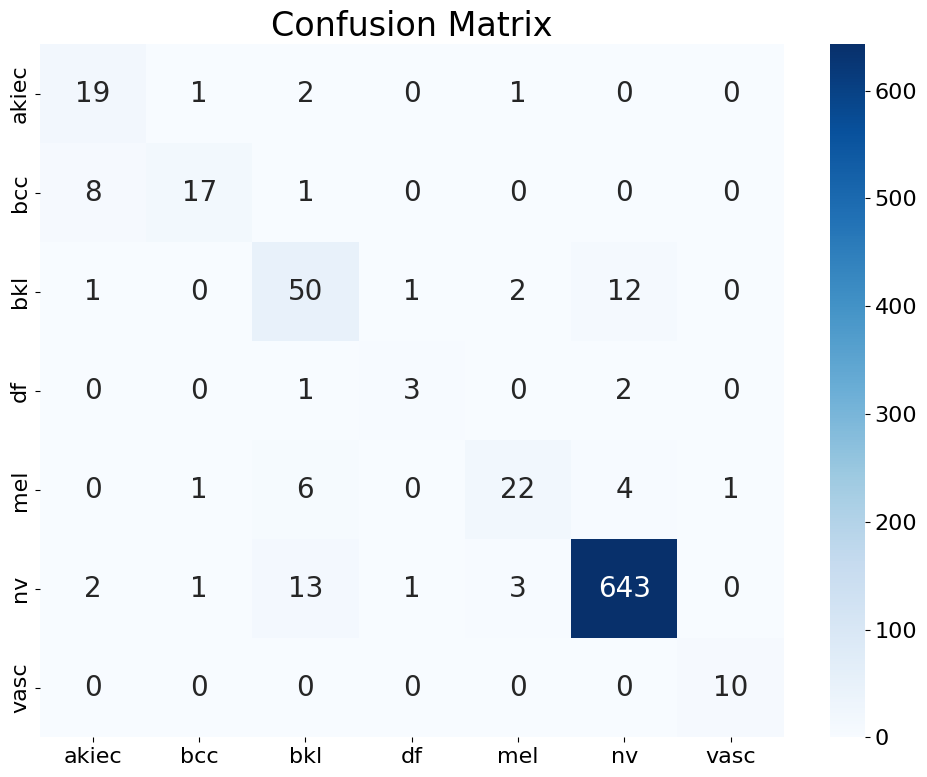

In [28]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

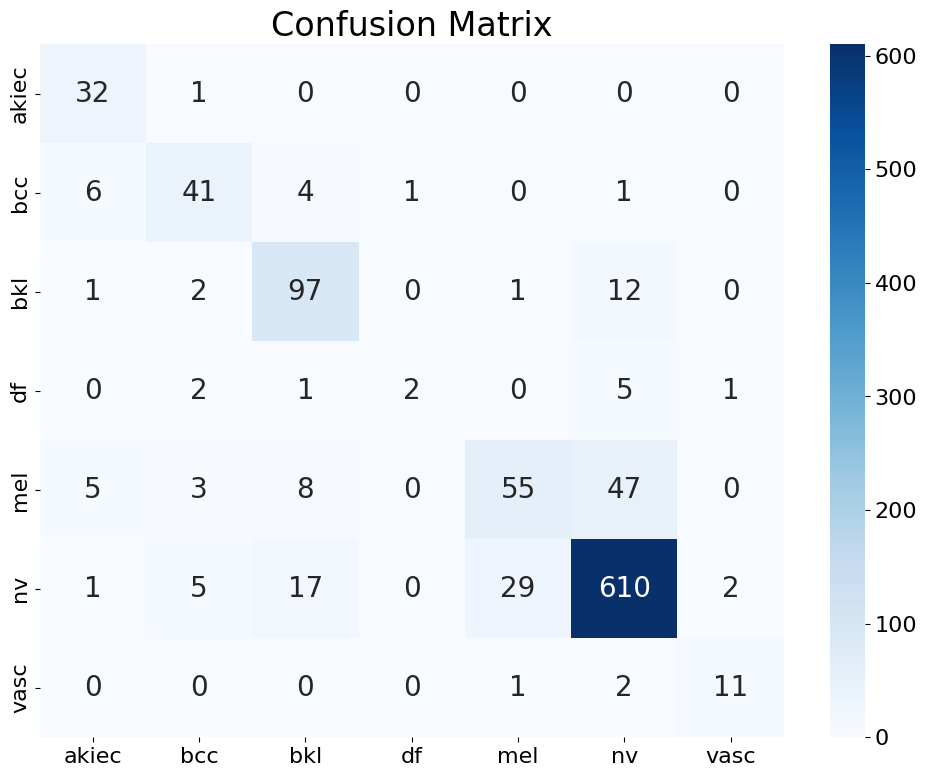

In [29]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [30]:
torch.cuda.memory.empty_cache()

In [31]:
network.load_state_dict(torch.load(save_PATH))
dict_test = {}
dict_size = {}
test_doc = "test525png384"#"test525png"#
for k in range(23,24):
    T_size = k
    for i in range(301,321):      
        get_data(i)
        print(f"size:{i}")
        for j in range(9):
            test()
            if dict_size.get(i) is None or dict_size[i] < test_acc:
                dict_size[i] = test_acc

                if dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

            elif dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

C:\Users\ToanGTV\AppData\Local\Temp\ipykernel_7416\1582139793.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(save_PATH))


Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20087
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20278
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19876
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20048
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20265
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20105
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19894
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.20138
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19922
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20360
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20576
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20128
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20446
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20133
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.20045
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.20152
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19813
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19794
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20074
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20066
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19788
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20018
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19909
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19735
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.20050
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19999
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19747
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20001
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19705
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.20146
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20037
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19800
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19733
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19868
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19762
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.614%
test_Loss: 0.19728
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19918
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19721
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19648
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19919
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19787
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19818
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19749
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19651
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.20057
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19829
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19881
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19743
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19809
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19950
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19764
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19688
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19833
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.20074
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19398
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19542
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19599
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19921
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19714
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19759
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19520
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19430
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.19636
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19342
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19250
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19464
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19539
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19828
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19443
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19201
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19667
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19596
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.19484
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19325
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19602
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19747
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.19595
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19489
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19347
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19435
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19756
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18973
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19369
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.19733
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.19489
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19495
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19242
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19128
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.406%
test_Loss: 0.19442
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19633
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19650
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19405
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19372
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19671
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19288
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19686
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19487
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19456
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19361
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19574
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19381
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19152
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19365
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19167
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19284
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19415
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19034
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19341
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19512
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19541
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19289
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19154
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19329
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19262
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19109
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19201
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19339
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19143
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19113
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19363
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19407
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.19529
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19442
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18992
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19451
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19517
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19004
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19325
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.19267
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19027
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18621
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18749
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19339
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19053
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19320
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18709
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19192
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18829
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19015
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18853
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18971
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18877
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18978
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.493%
test_Loss: 0.18733
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18878
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18980
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18922
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.19207
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18949
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18840
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.19295
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18940
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18779
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.285%
test_Loss: 0.18889
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18861
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18805
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18960
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18768
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.19031
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18893
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.19048
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19222
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.734%
test_Loss: 0.18807
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18970
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18644
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18922
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.647%
test_Loss: 0.19096
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18311
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18782
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18953
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18942
Best_eval:[92.271%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18288
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.889%
test_Loss: 0.18509
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.768%
test_Loss: 0.18583
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18800
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.372%
test_Loss: 0.18480
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.13%
test_Loss: 0.18576
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.251%
test_Loss: 0.18777
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:88.527%
test_Loss: 0.18762
Best_eval:[92.271%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:89.01%
test_Loss: 0.18617
Best_eval:[92.271%]


In [32]:
show.conclusion(img_title=img_title) 
print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [460]
[Test] ACC:92.27%.
[(23, 89.73429799079895)]
[(319, 89.73429799079895), (304, 89.61352705955505), (305, 89.49275612831116), (307, 89.49275612831116), (316, 89.49275612831116), (301, 89.37197923660278), (308, 89.37197923660278), (309, 89.37197923660278), (317, 89.37197923660278)]


In [33]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.6333  | 0.826  | 0.717 |          |
|  bcc   |    0.85   | 0.654  | 0.739 |          |
|  bkl   |   0.6849  | 0.758  | 0.719 |          |
|   df   |    0.6    |  0.5   | 0.545 |          |
|  mel   |   0.7857  | 0.647  |  0.71 |          |
|   nv   |   0.9728  |  0.97  | 0.971 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9227  |
+--------+-----------+--------+-------+----------+
